<a href="https://colab.research.google.com/github/syedabusafwan/ML-practice/blob/main/eye_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inputs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 734M/736M [00:03<00:00, 190MB/s]
100% 736M/736M [00:03<00:00, 212MB/s]


In [ ]:
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import copy # Needed for deep copying states if required

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


In [ ]:
# --- Configuration ---
DATA_DIR = "/content/dataset"
BATCH_SIZE = 32 # Keep or adjust based on GPU memory
EPOCHS = 30 # Increase epochs slightly for potentially harder multi-class task
LEARNING_RATE = 0.0005 # Might need slightly lower LR for fine-tuning multi-class
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "best_multiclass_eye_disease_resnet152_model.pth" # Updated save path
NUM_WORKERS = 2
RANDOM_SEED = 42

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    # These might slightly slow down training but improve reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")
print(f"Number of workers for DataLoader: {NUM_WORKERS}")
print(f"Data Directory: {DATA_DIR}")
print(f"Model save path: {MODEL_SAVE_PATH}")

Using device: cuda
Number of workers for DataLoader: 2
Data Directory: /content/dataset
Model save path: best_multiclass_eye_disease_resnet152_model.pth


# Data Preprocessing

In [ ]:
# --- Data Loading and Preparation ---

# Transformations (Using TrivialAugment for potentially better generalization on smaller dataset)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(), # Good automatic augmentation strategy
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset structure initially to get labels, classes, and perform split
try:
    initial_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transform) # Use basic transform for inspection
    if len(initial_dataset) == 0:
        raise ValueError("Dataset is empty or not found. Check DATA_DIR and dataset structure.")

    labels = np.array([label for _, label in initial_dataset.samples])
    class_names = initial_dataset.classes
    NUM_CLASSES = len(class_names) # <-- Determine number of classes automatically

    print(f"Dataset classes found: {class_names} ({NUM_CLASSES} classes)")
    print(f"Total images found: {len(initial_dataset)}")
    print(f"Initial Class distribution: {Counter(labels)}")
    # Check if distribution looks reasonable for the dataset description
    if NUM_CLASSES <= 1:
         print("Warning: Expected multiple classes, but found only {NUM_CLASSES}. Check dataset structure.")


except (FileNotFoundError, ValueError, Exception) as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the DATA_DIR is correct and the dataset follows the ImageFolder structure (e.g., DATA_DIR/class1/..., DATA_DIR/class2/...).")
    # Consider raising e or exit() if dataset loading fails critically
    raise e

# Train/Validation/Test split (e.g., 70/15/15 or 60/20/20 - adjust as needed for smaller dataset)
# Using 70/15/15 split here
splitter_train_valtest = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED) # 70% train, 30% temp
train_idx, temp_idx = next(splitter_train_valtest.split(np.zeros(len(labels)), labels))

temp_labels = labels[temp_idx]
# Split the 30% temp into 15% validation and 15% test (0.5 ratio of the temp set)
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)
val_idx_rel, test_idx_rel = next(splitter_val_test.split(np.zeros(len(temp_labels)), temp_labels))

# Map indices back to the original dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Create datasets with the *correct* transforms assigned to the underlying ImageFolder instances
# It's safer to instantiate the dataset with the correct transform before subsetting
train_dataset_instance = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
val_test_dataset_instance = datasets.ImageFolder(root=DATA_DIR, transform=val_test_transform)

train_data = Subset(train_dataset_instance, train_idx)
val_data = Subset(val_test_dataset_instance, val_idx)
test_data = Subset(val_test_dataset_instance, test_idx)


print(f"\nData Split:")
print(f"Train samples: {len(train_data)}, Class distribution: {Counter(labels[train_idx])}")
print(f"Validation samples: {len(val_data)}, Class distribution: {Counter(labels[val_idx])}")
print(f"Test samples: {len(test_data)}, Class distribution: {Counter(labels[test_idx])}")

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False) # drop_last=False usually preferred
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nDataloaders created with Batch Size: {BATCH_SIZE}")

Dataset classes found: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'] (4 classes)
Total images found: 4217
Initial Class distribution: Counter({np.int64(1): 1098, np.int64(3): 1074, np.int64(0): 1038, np.int64(2): 1007})

Data Split:
Train samples: 2951, Class distribution: Counter({np.int64(1): 768, np.int64(3): 752, np.int64(0): 726, np.int64(2): 705})
Validation samples: 633, Class distribution: Counter({np.int64(1): 165, np.int64(3): 161, np.int64(0): 156, np.int64(2): 151})
Test samples: 633, Class distribution: Counter({np.int64(1): 165, np.int64(3): 161, np.int64(0): 156, np.int64(2): 151})

Dataloaders created with Batch Size: 32


In [ ]:
# --- Model Definition ---
print("\n--- Defining Model ---")
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

print("Freezing all model parameters initially...")
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the later layers (fine-tuning) - start with just layer4 and fc
print("Unfreezing parameters in layer4 and the new fc layer...")
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer for multi-class classification
num_ftrs = model.fc.in_features
print(f"Original FC layer input features: {num_ftrs}")
model.fc = nn.Linear(num_ftrs, NUM_CLASSES) # <-- Output features = number of classes
print(f"Replaced FC layer for {NUM_CLASSES}-class classification.")
# The new fc layer automatically has requires_grad=True

model = model.to(DEVICE)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total model parameters: {total_params:,}")
print(f"Trainable model parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")


--- Defining Model ---


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 172MB/s]


Freezing all model parameters initially...
Unfreezing parameters in layer4 and the new fc layer...
Original FC layer input features: 2048
Replaced FC layer for 4-class classification.
Total model parameters: 58,152,004
Trainable model parameters: 14,972,932 (25.75%)


In [ ]:
# --- Loss Function, Optimizer, Scheduler ---
print("\n--- Setting up Loss, Optimizer, Scheduler ---")
# Loss Function: CrossEntropyLoss for multi-class classification. It combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(f"Loss function: {criterion}")

# Optimizer: Adam is a common choice. Filter ensures only trainable parameters are optimized.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=2e-4) # Added small weight decay
print(f"Optimizer: Adam with LR={LEARNING_RATE}, Weight Decay=1e-4")

# Learning Rate Scheduler: Reduces LR when validation loss stops improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True) # Adjusted patience/factor
print(f"Scheduler: ReduceLROnPlateau (mode='min', patience=4, factor=0.2)")


--- Setting up Loss, Optimizer, Scheduler ---
Loss function: CrossEntropyLoss()
Optimizer: Adam with LR=0.0005, Weight Decay=1e-4
Scheduler: ReduceLROnPlateau (mode='min', patience=4, factor=0.2)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# --- Training and Evaluation Functions ---

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device) # <-- Labels should be LongTensor for CrossEntropyLoss

        # Forward pass
        outputs = model(images) # Raw logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        with torch.no_grad():
            _, predicted_labels = torch.max(outputs, 1) # Get the index of the max log-probability
            correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

        # Optional: Print batch progress
        # if (i + 1) % 10 == 0:
        #     print(f"  Batch {i+1}/{len(loader)}, Loss: {loss.item():.4f}")


    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, loader, criterion, device, class_names):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    all_scores = [] # Store softmax probabilities for AUC

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device) # Labels are LongTensor

            outputs = model(images) # Raw logits
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            probabilities = torch.softmax(outputs, dim=1) # Convert logits to probabilities
            _, predicted_labels = torch.max(probabilities, 1) # Get predicted class index

            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            # Store for comprehensive metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_scores.extend(probabilities.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    # Calculate other metrics using sklearn
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_scores = np.array(all_scores)

    # Use 'weighted' average to account for potential class imbalance in metrics like F1
    precision_w = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall_w = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1_w = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    # Macro average treats all classes equally
    f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)


    # AUC (One-vs-Rest strategy for multi-class)
    auc_ovr_w = float('nan')
    try:
        if len(np.unique(all_labels)) > 1 and all_scores.shape[1] == len(class_names):
             auc_ovr_w = roc_auc_score(all_labels, all_scores, multi_class='ovr', average='weighted')
    except ValueError as e:
        print(f"   Warning: Could not calculate AUC (OvR Weighted). {e}")

    # Full classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names, zero_division=0, digits=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        "precision_weighted": precision_w,
        "recall_weighted": recall_w,
        "f1_weighted": f1_w,
        "f1_macro": f1_macro, # Often a good indicator for multi-class balance
        "auc_ovr_weighted": auc_ovr_w,
        "classification_report": report,
        "confusion_matrix": cm
    }
    return metrics

print("Done")

Done


In [ ]:
# --- Plotting Functions ---

def plot_history(history):
    """Plots training, validation, and test loss and accuracy.""" # Updated docstring
    # Check if test metrics are available
    has_test_data = 'test_loss' in history and 'test_acc' in history and len(history.get('test_loss', [])) > 0

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    epochs_range = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    axes[0].plot(epochs_range, history['train_loss'], 'o-', color='royalblue', label='Train Loss')
    axes[0].plot(epochs_range, history['val_loss'], 'o-', color='firebrick', label='Validation Loss')
    if has_test_data:
        axes[0].plot(epochs_range, history['test_loss'], 'o--', color='forestgreen', label='Test Loss') # <-- Added Test Loss plot
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, linestyle='--')

    # Plot Accuracy
    axes[1].plot(epochs_range, history['train_acc'], 'o-', color='royalblue', label='Train Accuracy')
    axes[1].plot(epochs_range, history['val_acc'], 'o-', color='firebrick', label='Validation Accuracy')
    if has_test_data:
        axes[1].plot(epochs_range, history['test_acc'], 'o--', color='forestgreen', label='Test Accuracy') # <-- Added Test Accuracy plot
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, linestyle='--')
    # Format Y-axis as percentage if accuracy is between 0 and 1
    if all(0 <= acc <= 1 for acc in history['train_acc'] + history['val_acc'] + history.get('test_acc', [])):
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2%}'))

    plt.suptitle('Training, Validation, and Test Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plots the confusion matrix."""
    fig, ax = plt.subplots(figsize=(max(6, len(class_names)*1.5), max(5, len(class_names)*1.2))) # Adjust size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

print("Done 2: Electric Boogaloo")

Done 2: Electric Boogaloo


In [ ]:
# --- Training Loop ---
print("\nRe-initializing Optimizer and Scheduler...")
# Re-create optimizer (ensure it only gets trainable params)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=LEARNING_RATE,
                       weight_decay=1e-4) # Use LR from config cell
# Re-create scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.2, # Use factor from config/previous cell
                                                 patience=4, # Use patience from config/previous cell
                                                 verbose=True)
print("Optimizer and Scheduler reset.")

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1_macro': [],
    'test_loss': [], 'test_acc': [], 'test_f1_macro': [] # <-- Added test keys
}
best_val_loss = float('inf')
best_val_acc = 0.0

print("\n--- Starting Training ---")
start_train_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    # --- Train ---
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validate ---
    # Pass class_names determined during data loading
    val_metrics = evaluate_model(model, val_loader, criterion, DEVICE, class_names)
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    val_f1_macro = val_metrics["f1_macro"]
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(val_f1_macro) # Store F1 macro

    # --- Test --- # <<< --- ADDED TEST EVALUATION PER EPOCH ---
    # Pass class_names determined during data loading
    test_metrics = evaluate_model(model, test_loader, criterion, DEVICE, class_names)
    test_loss = test_metrics["loss"]
    test_acc = test_metrics["accuracy"]
    test_f1_macro = test_metrics["f1_macro"]
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['test_f1_macro'].append(test_f1_macro)
    # ---------------------------------------------------------

    # --- Scheduler Step ---
    scheduler.step(val_loss) # Step based on validation loss

    # --- Print Epoch Results (with Test metrics) ---
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Time: {epoch_time:.2f}s | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} (F1m: {val_f1_macro:.4f}) | " # Added F1m for reference
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f} (F1m: {test_f1_macro:.4f})") # <-- Added Test metrics

    # --- Save Best Model Checkpoint (Dictionary based on Val Loss) ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"   -> Val Loss improved to {best_val_loss:.4f}. Saving Model Checkpoint...")
        checkpoint = {
            'epoch': epoch + 1,
            'num_classes': NUM_CLASSES, # Already NUM_CLASSES in multi-class code
            'class_names': class_names, # Already class_names in multi-class code
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_metrics': val_metrics # Save all validation metrics from this epoch
        }
        try:
            torch.save(checkpoint, MODEL_SAVE_PATH)
        except Exception as e:
            print(f"   *Error saving checkpoint*: {e}")

    # Optional: Save based on best validation accuracy instead/as well
    current_val_acc = val_metrics["accuracy"] # Get current val acc
    if current_val_acc > best_val_acc:
       best_val_acc = current_val_acc # Update best accuracy
       print(f"   -> Val Accuracy improved to {best_val_acc:.4f}. Saving Accuracy Checkpoint...") # Update print
       # Note: Saving the 'checkpoint' dict created earlier for best loss.
       # This dict contains the current epoch's state and metrics.
       try: # <<< Added try
           torch.save(checkpoint, "best_acc_checkpoint.pth") # Save to a different file
       except Exception as e: # <<< Added except
           print(f"   *Error saving accuracy checkpoint*: {e}")


total_train_time = time.time() - start_train_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Loss achieved: {best_val_loss:.4f}")
print(f"Best model checkpoint saved to: {MODEL_SAVE_PATH}")


Re-initializing Optimizer and Scheduler...
Optimizer and Scheduler reset.

--- Starting Training ---
Epoch 1/30 | Time: 56.73s | LR: 0.000500 | Train Loss: 0.7690, Acc: 0.7845 | Val Loss: 0.5499, Acc: 0.9100 (F1m: 0.9087) | Test Loss: 0.5740, Acc: 0.8942 (F1m: 0.8921)
   -> Val Loss improved to 0.5499. Saving Model Checkpoint...
   -> Val Accuracy improved to 0.9100. Saving Accuracy Checkpoint...
Epoch 2/30 | Time: 50.86s | LR: 0.000500 | Train Loss: 0.5862, Acc: 0.8872 | Val Loss: 0.5849, Acc: 0.9100 (F1m: 0.9094) | Test Loss: 0.6111, Acc: 0.8641 (F1m: 0.8638)
Epoch 3/30 | Time: 53.23s | LR: 0.000500 | Train Loss: 0.5381, Acc: 0.9126 | Val Loss: 0.4990, Acc: 0.9321 (F1m: 0.9314) | Test Loss: 0.5512, Acc: 0.8957 (F1m: 0.8939)
   -> Val Loss improved to 0.4990. Saving Model Checkpoint...
   -> Val Accuracy improved to 0.9321. Saving Accuracy Checkpoint...
Epoch 4/30 | Time: 49.14s | LR: 0.000500 | Train Loss: 0.5117, Acc: 0.9302 | Val Loss: 0.5054, Acc: 0.9289 (F1m: 0.9269) | Test Loss


--- Evaluating on Test Set using Best Model Checkpoint ---
Successfully loaded model state from checkpoint saved at epoch 16 (Val Loss: 0.4673)
Running evaluation on the test dataset...

--- Test Set Performance ---
Test Loss:             0.5157
Test Accuracy:         0.9115
Test F1 (Weighted):    0.9105
Test F1 (Macro):       0.9090
Test Precision (Wt):   0.9129
Test Recall (Wt):      0.9115
Test AUC (OvR Wt):     0.9863

Classification Report:
                      precision    recall  f1-score   support

            cataract     0.9141    0.9551    0.9342       156
diabetic_retinopathy     0.9940    1.0000    0.9970       165
            glaucoma     0.9070    0.7748    0.8357       151
              normal     0.8343    0.9068    0.8690       161

            accuracy                         0.9115       633
           macro avg     0.9123    0.9092    0.9090       633
        weighted avg     0.9129    0.9115    0.9105       633


Plotting Test Set Confusion Matrix:


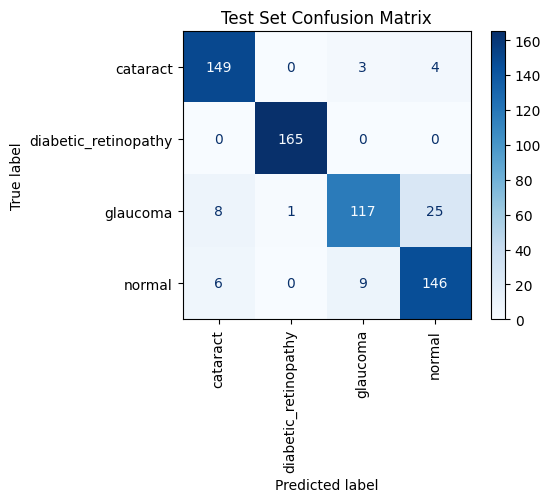

finally done, bye-bye


In [ ]:
# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set using Best Model Checkpoint ---")

# Load the best model checkpoint
try:
    # Instantiate a new model instance or use the current one
    # Important: Ensure model architecture (NUM_CLASSES) matches the checkpoint
    eval_model = models.resnet152() # Don't need pretrained weights here, will be loaded
    # Modify the final layer to match the saved model's architecture
    num_ftrs = eval_model.fc.in_features
    eval_model.fc = nn.Linear(num_ftrs, NUM_CLASSES) # Use NUM_CLASSES determined earlier
    eval_model = eval_model.to(DEVICE)

    # Load the checkpoint dictionary
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE, weights_only=False)

    # Strict loading is default, set strict=False if some keys mismatch (e.g. if optimizer isn't saved/loaded)
    eval_model.load_state_dict(checkpoint['model_state_dict'])

    loaded_epoch = checkpoint.get('epoch', 'N/A') # Use .get for robustness
    loaded_val_loss = checkpoint.get('best_val_loss', float('nan'))
    print(f"Successfully loaded model state from checkpoint saved at epoch {loaded_epoch} (Val Loss: {loaded_val_loss:.4f})")

    # Get class names from checkpoint if available, otherwise use globally defined ones
    eval_class_names = checkpoint.get('class_names', class_names)

    # Evaluate on the test set
    print("Running evaluation on the test dataset...")
    test_metrics = evaluate_model(eval_model, test_loader, criterion, DEVICE, eval_class_names)

    print("\n--- Test Set Performance ---")
    print(f"Test Loss:             {test_metrics['loss']:.4f}")
    print(f"Test Accuracy:         {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Weighted):    {test_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (Macro):       {test_metrics['f1_macro']:.4f}")
    print(f"Test Precision (Wt):   {test_metrics['precision_weighted']:.4f}")
    print(f"Test Recall (Wt):      {test_metrics['recall_weighted']:.4f}")
    print(f"Test AUC (OvR Wt):     {test_metrics.get('auc_ovr_weighted', float('nan')):.4f}")

    print("\nClassification Report:")
    print(test_metrics['classification_report'])

    print("\nPlotting Test Set Confusion Matrix:")
    plot_confusion_matrix(test_metrics['confusion_matrix'], eval_class_names, title='Test Set Confusion Matrix')

    # You can now access other saved info from the best checkpoint if needed
    # best_epoch_val_metrics = checkpoint.get('best_val_metrics')
    # if best_epoch_val_metrics:
    #     print("\nMetrics from the epoch the best model was saved:")
    #     # print(best_epoch_val_metrics)


except FileNotFoundError:
    print(f"Error: Could not find the saved model checkpoint at {MODEL_SAVE_PATH}.")
    print("Cannot perform final test evaluation with the best model.")
except KeyError as e:
    print(f"Error loading checkpoint: Missing key {e}. The checkpoint might be corrupted or saved incorrectly.")
except Exception as e:
    print(f"An error occurred during test set evaluation: {e}")
    # You might want to print the traceback for more details
    import traceback
    traceback.print_exc()

print("finally done, bye-bye")

In [ ]:
# prompt: define a function where i will give image path and it will show image with predict label with given true level

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_and_show_image(model, image_path, true_label, transform, class_names, device):
    """
    Loads an image, predicts its class using the model, and displays the image
    along with the true and predicted labels.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        image_path (str): The path to the image file.
        true_label (str): The true label of the image.
        transform (torchvision.transforms.Compose): The image transformation to apply.
        class_names (list): A list of class names in the order corresponding to model outputs.
        device (torch.device): The device to perform inference on ('cuda' or 'cpu').
    """
    try:
        # Load the image
        image = Image.open(image_path).convert('RGB') # Ensure image is RGB

        # Apply transformations
        image_tensor = transform(image).unsqueeze(0).to(device) # Add batch dimension and send to device

        # Set model to evaluation mode
        model.eval()

        # Perform inference
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_class_index = torch.max(probabilities, 1)

        # Get predicted class name
        predicted_label = class_names[predicted_class_index.item()]

        # Display the image and labels
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()

        print(f"Image Path: {image_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Probabilities: {probabilities.squeeze().cpu().numpy()}") # Display probabilities

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

# Example Usage (assuming you have loaded the best model and defined necessary variables):
# Ensure you have the best model loaded into 'eval_model' as shown in the preceding code
# Ensure you have 'val_test_transform', 'class_names', and 'DEVICE' defined

# # Example 1: Pick a sample image from the test set
# # You need to know the structure of your test_data subset to get an image path and true label
# # This is a simplified example, you might need to iterate through test_data to find a specific image
# # For demonstration, let's assume you know an image path and its true label
# # Replace with actual image path and true label from your dataset
# example_image_path = '/content/dataset/cataract/0_left.jpg' # Example path
# example_true_label = 'cataract' # Example true label

# print("\n--- Demonstrating Prediction on a Sample Image ---")
# predict_and_show_image(eval_model, example_image_path, example_true_label, val_test_transform, class_names, DEVICE)

# # Example 2: Pick another image
# another_image_path = '/content/dataset/normal/0_left.jpg'
# another_true_label = 'normal'
# prompt: define a function where i will give image path and it will show image with predict label with given true level

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def predict_and_show_image(model, image_path, true_label, transform, class_names, device):
    """
    Loads an image, predicts its class using the model, and displays the image
    along with the true and predicted labels.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        image_path (str): The path to the image file.
        true_label (str): The true label of the image.
        transform (torchvision.transforms.Compose): The image transformation to apply.
        class_names (list): A list of class names in the order corresponding to model outputs.
        device (torch.device): The device to perform inference on ('cuda' or 'cpu').
    """
    try:
        # Load the image
        image = Image.open(image_path).convert('RGB') # Ensure image is RGB

        # Apply transformations
        image_tensor = transform(image).unsqueeze(0).to(device) # Add batch dimension and send to device

        # Set model to evaluation mode
        model.eval()

        # Perform inference
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_class_index = torch.max(probabilities, 1)

        # Get predicted class name
        predicted_label = class_names[predicted_class_index.item()]

        # Display the image and labels
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()

        print(f"Image Path: {image_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Probabilities: {probabilities.squeeze().cpu().numpy()}") # Display probabilities

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

# Example Usage (assuming you have loaded the best model and defined necessary variables):
# Ensure you have the best model loaded into 'eval_model' as shown in the preceding code
# Ensure you have 'val_test_transform', 'class_names', and 'DEVICE' defined

# # Example 1: Pick a sample image from the test set
# # You need to know the structure of your test_data subset to get an image path and true label
# # This is a simplified example, you might need to iterate through test_data to find a specific image
# # For demonstration, let's assume you know an image path and its true label
# # Replace with actual image path and true label from your dataset
# example_image_path = '/content/dataset/cataract/0_left.jpg' # Example path
# example_true_label = 'cataract' # Example true label

# print("\n--- Demonstrating Prediction on a Sample Image ---")
# predict_and_show_image(eval_model, example_image_path, example_true_label, val_test_transform, class_names, DEVICE)

# # Example 2: Pick another image
# another_image_path = '/content/dataset/normal/0_left.jpg'
# another_true_label = 'normal'
# print("\n--- Demonstrating Prediction on Another Sample Image ---")
# predict_and_show_image(eval_model, another_image_path, another_true_label, val_test_transform, class_names, DEVICE)

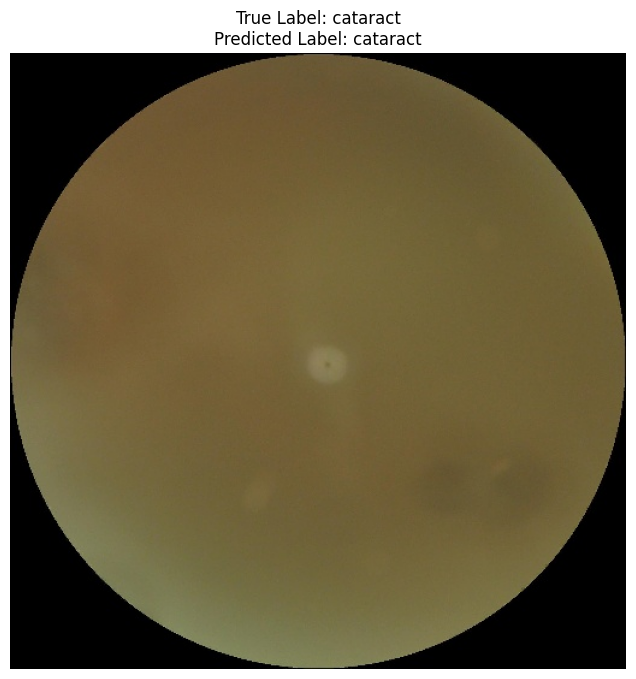

Image Path: /content/dataset/cataract/0_left.jpg
True Label: cataract
Predicted Label: cataract
Prediction Probabilities: [0.9433325  0.02352449 0.01850258 0.01464033]


In [ ]:
predict_and_show_image(model, '/content/dataset/cataract/0_left.jpg', 'cataract', val_test_transform, class_names, DEVICE)

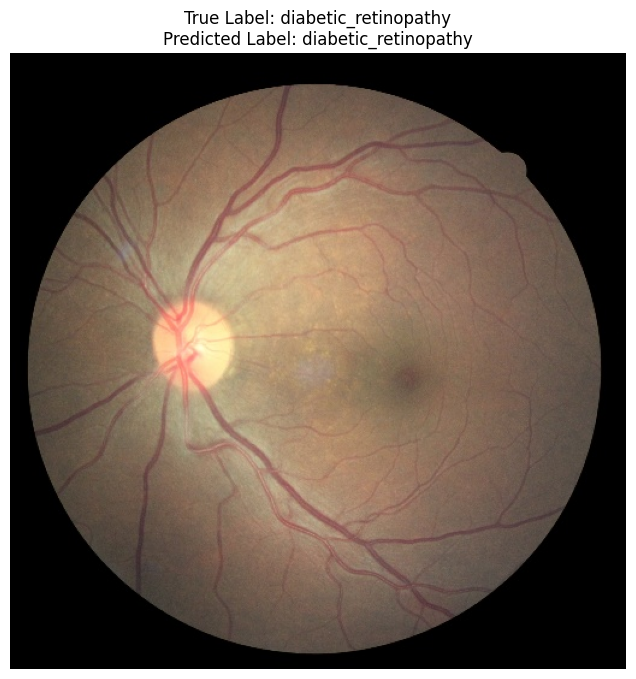

Image Path: /content/dataset/diabetic_retinopathy/10003_left.jpeg
True Label: diabetic_retinopathy
Predicted Label: diabetic_retinopathy
Prediction Probabilities: [0.02892104 0.91306764 0.0298954  0.02811592]


In [ ]:
predict_and_show_image(model, '/content/dataset/diabetic_retinopathy/10003_left.jpeg', 'diabetic_retinopathy', val_test_transform, class_names, DEVICE)

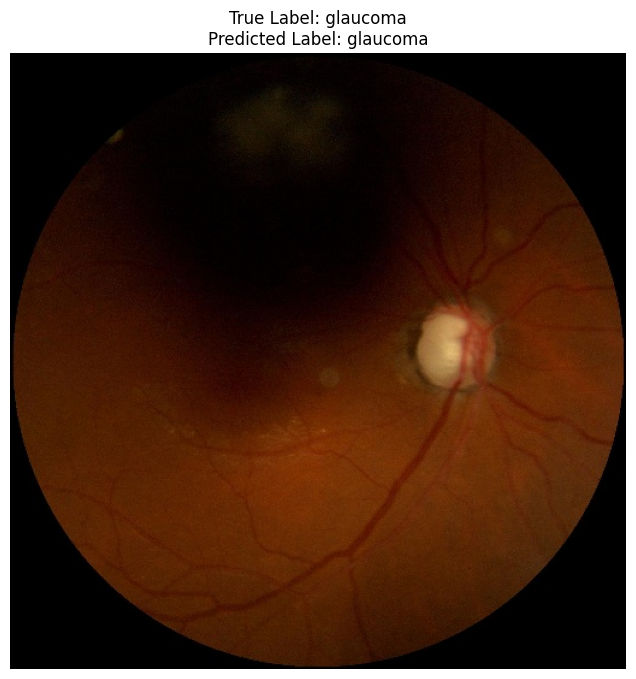

Image Path: /content/dataset/glaucoma/1209_right.jpg
True Label: glaucoma
Predicted Label: glaucoma
Prediction Probabilities: [0.01571347 0.01935739 0.9497358  0.01519331]


In [ ]:
predict_and_show_image(model, '/content/dataset/glaucoma/1209_right.jpg', 'glaucoma', val_test_transform, class_names, DEVICE)

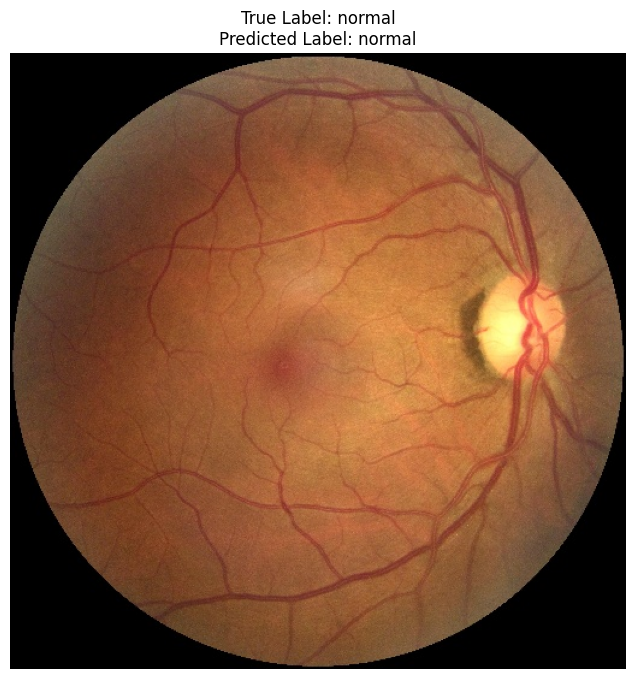

Image Path: /content/dataset/normal/1060_right.jpg
True Label: normal
Predicted Label: normal
Prediction Probabilities: [0.02450917 0.01785128 0.0180695  0.93957   ]


In [ ]:
predict_and_show_image(model, '/content/dataset/normal/1060_right.jpg', 'normal', val_test_transform, class_names, DEVICE)

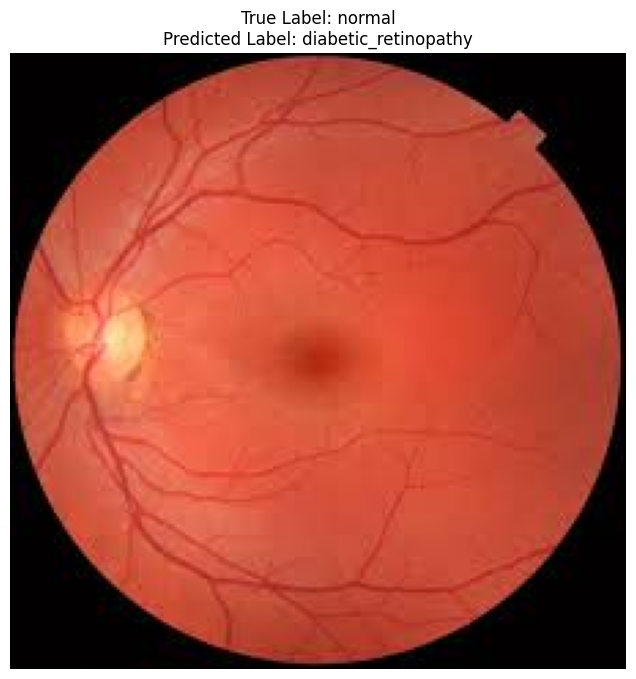

Image Path: /content/download2.jpg
True Label: normal
Predicted Label: diabetic_retinopathy
Prediction Probabilities: [0.01186988 0.7645005  0.21499686 0.00863273]


In [ ]:
predict_and_show_image(model, '/content/download2.jpg', 'normal', val_test_transform, class_names, DEVICE)